In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from os import path
import zipfile


In [141]:
if not path.exists('./goodreads10k/ratings.csv'):
    with zipfile.ZipFile("./goodreads10k/goodreads10k.zip","r") as zip_ref:
        zip_ref.extractall("./goodreads10k")

In [142]:
import pandas as pd

In [143]:
books = pd.read_csv('./goodreads10k/books.csv')
ratings = pd.read_csv('./goodreads10k/ratings.csv')

In [144]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


#### Create dict with goodreads_book_id : category pairs.

The category of a book is its most frequent category tag. 

In [145]:
from goodreads10k.categories import get_categories
category_tags = [
    #'Art',
    #'Biography'
    #'Business',
    #"Chick-Lit",
    "Children-s",
    #'Christian',
    'Classics',
    #'Comics',
    #'Contemporary',
    #'Cookbooks',
    #'Crime',
    'Fantasy',
    #'Fiction',
    #'Graphic-Novels',
    #'Historical-Fiction',
    #'History',
    'Horror',
    #'Humor-and-Comedy',
    #'Manga',
    'Memoir',
    #'Music',
    'Mystery',
    #'Nonfiction',
    'Paranormal',
    #'Philosophy',
    'Poetry',
    #'Psychology',
    #'Religion',
    'Romance',
    #'Science',
    #'Science-Fiction',
    #'Self-Help',
    #'Suspense'
    #'Spirituality',
    #'Sports',
    'Thriller',
    #'Travel',
    #'Young-Adult'
    ]

book_categories = get_categories(category_tags) 

#### Set color for each category

In [146]:
from bokeh.palettes import Category10, Category20, Accent, Set3 # color palletes

book_category_series = books['book_id'].apply(lambda bid: book_categories[bid] if bid in book_categories else 'other')

category_color = { ct.lower(): Category10[10][idx]  for idx, ct in enumerate(category_tags)}

book_category_colors = pd.Series([category_color[i] if i in category_color else Category20[20][15] for i in book_category_series ])

In [147]:
book_category_colors[book_category_series == "children-s"]

76      #1f77b4
84      #1f77b4
88      #1f77b4
101     #1f77b4
132     #1f77b4
         ...   
9908    #1f77b4
9911    #1f77b4
9918    #1f77b4
9932    #1f77b4
9973    #1f77b4
Length: 455, dtype: object

In [148]:
from bokeh.plotting import figure, show, output_notebook, save, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20b
import pandas as pd

output_notebook()

df_combine = pd.read_csv('./EmbeddingGraph/books_final_df.csv')
df_combine['node_color'] = book_category_colors
#df_combine.loc[df_combine.category == 'romance', ['node_color']] = Category20b[20][3]

source = ColumnDataSource(dict(
    x=df_combine['x_tsne'],
    y=df_combine['y_tsne'],
    title= df_combine['title'],
    fill_color=df_combine['node_color'],
  #  legend_label=book_category_series
))

title = 'PCA visualization of embeddings'

plot_lda = figure(plot_width=2000, plot_height=600,
                     title='Find your boook!', tools="pan,wheel_zoom,box_zoom,reset,hover",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,
                alpha=0.99, size=10,
                fill_color='fill_color') 
                #fill_color=factor_cmap('legend', palette=Category20b[20], factors=df_combine.category.unique()),
                #legend_group='legend_label')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}

#show(plot_lda)


Loading BokehJS ...

In [152]:
from bokeh.models import ColumnDataSource, Div, Select, Slider, TextInput, RangeSlider, CheckboxGroup
import numpy as np 
from bokeh.layouts import column, layout
from bokeh.io import curdoc
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler


background_color = 'white'

genre = CheckboxGroup(labels=category_tags, active=list(range(0, len(category_tags))), background=background_color, height=250, margin=(50,5,5,5))

year = RangeSlider(start=1600, end=2020, value=(1600,2020), step=1, title="Year of publication",  background=background_color, width=280)

average_rating =  RangeSlider(start=0, end=5, value=(0,5), step=.1, title="Rating",  background=background_color, width=280)

ratings_count = RangeSlider(start=0, end=1000000, value=(1,1000000), step=1, title="Amount of ratings",  background=background_color, width=280)

authors =  TextInput(value="", title="Author",  background=background_color, width=280)

title  =  TextInput(value="", title="Title",  background=background_color, width=280)


def select_books():
    
    selected =  df_combine.copy()
    selected = selected.loc[(selected["node_color"].isin( [ list(category_color.values())[x] for x in genre.active]))]
    
    selected = selected.loc[ (selected["original_publication_year"] <= year.value[1]) & (selected["original_publication_year"] >=year.value[0]) &
                 (selected["average_rating"] <= average_rating.value[1]) & (selected["average_rating"] >= average_rating.value[0] ) &
                 (selected["ratings_count"] <= ratings_count.value[1]) & (selected["ratings_count"] >= ratings_count.value[0] ) ]
     
    selected = selected.loc[selected["authors"].str.contains(authors.value) == True ] 
    selected = selected.loc[selected["title"].str.contains(title.value) == True] 

    return selected

def update():
    df = select_books()
    source.data = dict(
        x=df['x_tsne'],
        y=df['y_tsne'],
        title= df['title'],
        fill_color=df['node_color']
    )



    
controls = [authors, title, year, average_rating, ratings_count]    
for control in controls:
    control.on_change('value', lambda attr, old, new: update())
genre.on_change('active', lambda attr, old, new: update())
controls = [genre] + controls

inputs = column(*controls, width=300, height=200,  background=background_color, sizing_mode="fixed")

plot_lda.sizing_mode = "stretch_both"
l = layout([[inputs, plot_lda]]  , sizing_mode="stretch_both") 

update()  # initial load of the data


def modify_doc(doc):
    doc.add_root(l)

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

#### Create legend of plot.


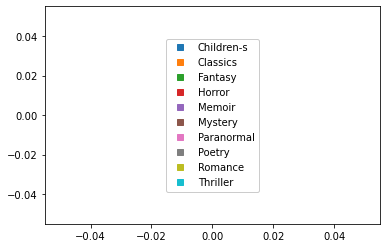

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

colors = list(category_color.values()) 
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles = [f("s", colors[i]) for i in range(len(list(category_color.values()) ))]

labels = category_tags
legend = plt.legend(handles, labels, loc=len(list(category_color.values()) ), framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    
export_legend(legend)

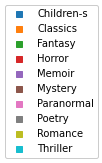

In [151]:
Image(filename='legend.png') 